In [68]:
import os
import time
import glob
import numpy as np
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt

In [69]:
dataset_path = './../../datasets/IAMsynth_full/train'
dataset_path_target = './../../datasets/IAMsynth_full/train/struck_gt/'

In [70]:
input_paths = glob.glob(dataset_path + '/struck/*.png')
target_paths = glob.glob(dataset_path + '/struck_gt/*.png')
print(input_paths[0], target_paths[0])

./../../datasets/IAMsynth_full/train/struck/a02-120-02-01.png ./../../datasets/IAMsynth_full/train/struck_gt/a02-120-02-01.png


In [71]:
BUFFER_SIZE = 400
EPOCHS = 100
LAMBDA = 100
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
patch_size = 8
num_patches = (IMG_HEIGHT // patch_size) ** 2
projection_dim = 64
embed_dim = 64
num_heads = 2 
ff_dim = 32

In [72]:
def load(path):

    # v = path.split("/")[-1].split("_", 1)
    # name, strikethrough_type = v[0], v[1]

    name = path.split("/")[-1]

    input_path = path
    # target_path = dataset_path_target + '/gt/' + name + '.png'
    target_path = dataset_path_target + name

    input_image = tf.io.read_file(input_path)
    input_image = tf.image.decode_png(input_image)
    
    target_image = tf.io.read_file(target_path)
    target_image = tf.image.decode_png(target_image)
    
    input_image = tf.cast(input_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)


    return input_image, target_image

In [73]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [74]:
def normalize(input_image, target_image):
    input_image = input_image / 255
    target_image = target_image / 255

    return input_image, target_image

In [75]:
def load_image_train(depth_path):
    input_image, target = load(depth_path)
    if input_image.shape[0] > IMG_WIDTH:
        return None
    if input_image.shape[1] > IMG_HEIGHT:
        return None
    input_image, target = resize(input_image, target,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, target = normalize(input_image, target)
    return input_image, target

In [76]:
def load_data_generator(input_paths):
    for input_path in input_paths:
        v = load_image_train(input_path)
        if v is None:
            continue

        yield v

In [77]:
from matplotlib import pyplot as plt
import numpy as np

In [78]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [79]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [80]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [81]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [82]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [83]:
from tensorflow.keras import layers

def Generator():

    inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    x = TransformerBlock(64, num_heads, ff_dim)(encoded_patches)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = layers.Reshape((8, 8, 1024))(x)

    x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=512)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=256)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = residual_block(x, downsample=False, filters=64)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(4, 4), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=32)

    x = layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    print(inputs)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [84]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
patches_1 (Patches)             (None, None, 64)     0           input_2[0][0]                    
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 1024, 64)     69696       p

In [85]:
tf.config.run_functions_eagerly(True)

In [86]:
def generate_images(model, test_input, tar):
    test_input = np.expand_dims(test_input, axis=0)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], np.array(tar).reshape((256, 256, 3)), np.array(prediction[0]).reshape((256, 256, 1))]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

def generate_batch_images(model, test_input, tar):
    for i in range(len(test_input)):
        prediction = model(test_input, training=True)
        plt.figure(figsize=(15, 15))

        display_list = [test_input[i], tar[i], prediction[i]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0, 1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis('off')
        plt.show()

In [87]:
@tf.function
def train_step(input_image, target):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape:
            gen_output = generator(input_image, training=True)
            gen_total_loss = tf.reduce_mean(tf.abs(target - gen_output))
        

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))

In [88]:
from tqdm import tqdm
def fit(train_ds, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()

        display.clear_output(wait=True)


        for n, v in train_ds.enumerate():
            struck, clean = np.swapaxes(v, 0, 1)

            train_step(struck, clean)

        generator.save_weights(f'strikethrough.ipynb-weights.h5')

In [91]:
train_dataset = tf.data.Dataset.from_generator(lambda: load_data_generator(input_paths), output_shapes=(2, IMG_WIDTH, IMG_HEIGHT, 1), output_types=(tf.float32))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [90]:
fit(train_dataset, EPOCHS)

2022-06-13 15:33:46.528613: W tensorflow/core/framework/op_kernel.cc:1755] Invalid argument: ValueError: `generator` yielded an element of shape (2, 256, 256, 1) where an element of shape (2, 256, 256, 3) was expected.
Traceback (most recent call last):

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1005, in generator_py_func
    raise ValueError(

ValueError: `generator` yielded an element of shape (2, 256, 256, 1) where an element of shape (2, 256, 256, 3) was expected.


  0%|          | 0/100 [00:00<?, ?it/s]


InvalidArgumentError: ValueError: `generator` yielded an element of shape (2, 256, 256, 1) where an element of shape (2, 256, 256, 3) was expected.
Traceback (most recent call last):

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 249, in __call__
    ret = func(*args)

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/home/markb/anaconda3/envs/paired_strikethrough_removal/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1005, in generator_py_func
    raise ValueError(

ValueError: `generator` yielded an element of shape (2, 256, 256, 1) where an element of shape (2, 256, 256, 3) was expected.


	 [[{{node PyFunc}}]] [Op:IteratorGetNext]

In [ ]:
generator.save_weights('gen-depth-weights.h5')


In [176]:
generator.load_weights('../src/weights/strikethrough.ipynb-weights.h5')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


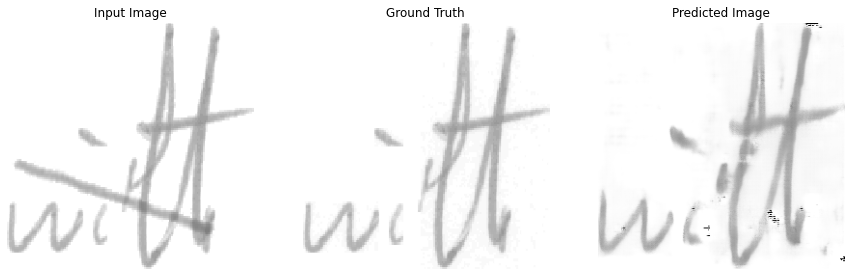

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


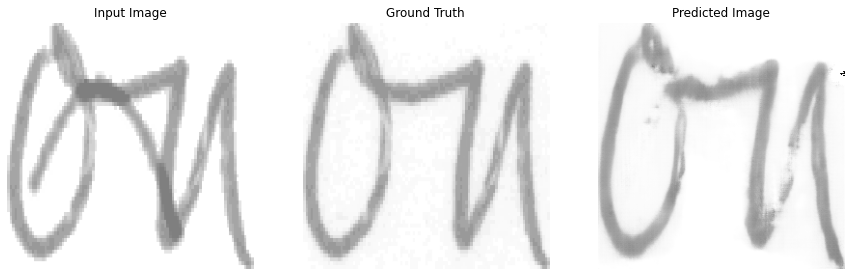

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


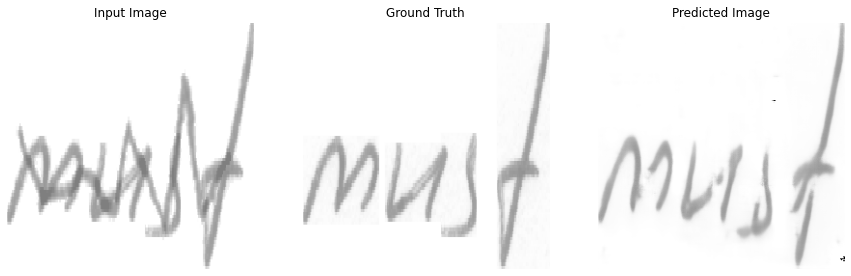

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


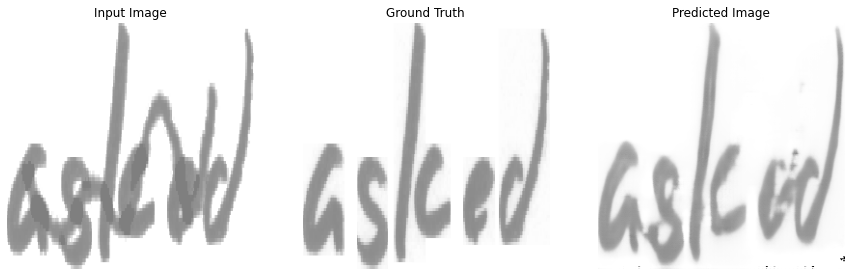

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


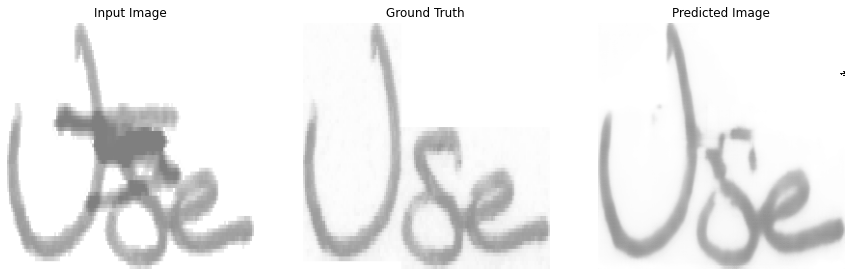

In [182]:
for e in train_dataset.take(5):
    single = e[0]
    example_input = single[0]
    example_target = single[1]
    generate_images(generator, example_input, example_target)